## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Kaggle Notebook

Resources: 
- https://github.com/huggingface/notebooks/blob/main/diffusers/SDXL_DreamBooth_LoRA_.ipynb
- https://github.com/huggingface/diffusers/blob/main/docs/source/en/using-diffusers/sdxl.md
- https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
- https://github.com/huggingface/diffusers/blob/main/docs/source/en/using-diffusers/sdxl.md#image-to-image

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Mon Mar 25 16:21:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft invisible-watermark>=0.2.0 -q

Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-03-25 16:22:41--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82552 (81K) [text/plain]
Saving to: 'train_dreambooth_lora_sdxl.py.2'

train_dreambooth_lo 100%[===================>]  80.62K  --.-KB/s    in 0.02s   

2024-03-25 16:22:42 (5.22 MB/s) - 'train_dreambooth_lora_sdxl.py.2' saved [82552/82552]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

In [5]:
import os
# from google.colab import files

# pick a name for the image folder
local_dir = "/kaggle/working/acne04/acne0_1024" #@param
# os.makedirs(local_dir)
# os.chdir(local_dir)

# choose and upload local images into the newly created directory
# uploaded_images = files.upload()
os.chdir("/kaggle/working") # back to parent directory

**Option 2:** download example images from the hub:

In [6]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("hf_write_token")

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "/kaggle/working/acne04"
snapshot_download(
    "ManuelHettich/acne04",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Preview the images:

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

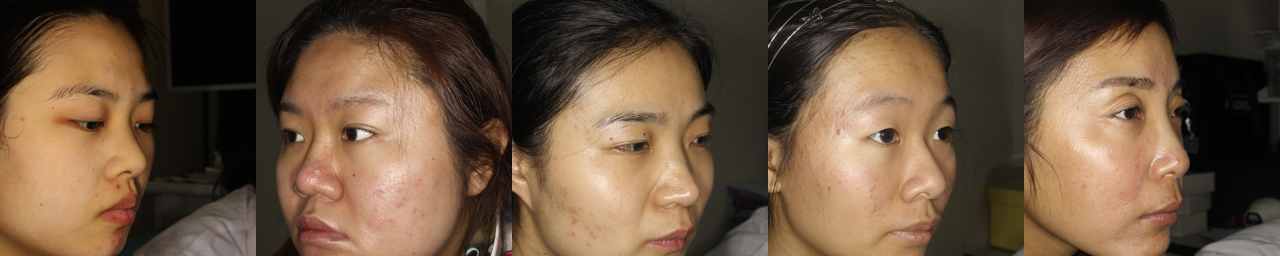

In [9]:
import glob

# change path to display images from your local dir
img_paths = "/kaggle/working/acne04/acne0_1024/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [10]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "/kaggle/working/acne04/acne0_1024/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

## Prep for training 💻

Initialize `accelerate`:

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [12]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("hf_write_token")

In [13]:
# lets verify
!huggingface-cli whoami

ManuelHettich
orgs:  labgpt


In [14]:
# Does not work in Kaggle
# from huggingface_hub import notebook_login
# notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [15]:
# !pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [16]:
#!/usr/bin/env bash
#!accelerate launch train_dreambooth_lora_sdxl.py \
#  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
#  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
#  --dataset_name="dog" \
#  --output_dir="corgy_dog_LoRA" \
#  --caption_column="prompt"\
#  --mixed_precision="fp16" \
#  --instance_prompt="a photo of TOK dog" \
#  --resolution=1024 \
#  --train_batch_size=1 \
#  --gradient_accumulation_steps=3 \
#  --gradient_checkpointing \
#  --learning_rate=1e-4 \
#  --snr_gamma=5.0 \
#  --lr_scheduler="constant" \
#  --lr_warmup_steps=0 \
#  --mixed_precision="fp16" \
#  --use_8bit_adam \
#  --max_train_steps=500 \
#  --checkpointing_steps=717 \
#  --seed="0"

In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --output_dir="/kaggle/working/acne0_filtered_all_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_data_dir="/kaggle/working/acne04/acne0_1024" \
  --instance_prompt="photo of a person with acne0" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=250 \
  --seed="0"

2024-03-25 16:23:38.996718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 16:23:38.996731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 16:23:38.996774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 16:23:38.996824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 16:23:39.184179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory

### Save your model to the hub and check it out 🔥

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "/kaggle/working/acne0_filtered_all_LoRA" #@param
model_name = "acne0_LoRA_filtered_all"
username = whoami(token=user_secrets.get_secret("hf_write_token"))["name"]
repo_id = f"{username}/{model_name}"

In [ ]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="photo of a person with acne0",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora=''
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

Let's generate some images with it!

## Inference 🐕

### Txt2Img

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

In [ ]:
prompt = "photo of a person with acne0, close-up, portrait, high quality" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

### Img2Img

In [ ]:
import os

# pick a name for the image folder
local_dir = "/kaggle/working/acne04/acne0_1024" #@param
os.chdir("/kaggle/working")

In [ ]:
# Lower memory usage
# https://huggingface.co/docs/diffusers/main/en/optimization/memory
# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [ ]:
!pip install xformers -q

In [ ]:
import torch
from diffusers import AutoPipelineForImage2Image, AutoencoderKL, UniPCMultistepScheduler
from diffusers.utils import load_image, make_image_grid

# Image-to-Image
# https://github.com/huggingface/diffusers/blob/main/docs/source/en/using-diffusers/sdxl.md#image-to-image

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                  vae=vae,
                                                  torch_dtype=torch.float16,
                                                  variant="fp16",
                                                  use_safetensors=True)
pipe.load_lora_weights(repo_id)
# _ = pipe.to("cuda")
# Remove limitation by GPU VRAM
# _ = pipe.enable_model_cpu_offload()

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# improve the inference speed by 20-30%
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

pipe = pipe.to("cuda")

# https://huggingface.co/docs/diffusers/main/en/optimization/memory#tiled-vae
pipe.enable_vae_tiling()

# https://huggingface.co/docs/diffusers/main/en/optimization/memory#memory-efficient-attention
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
with torch.inference_mode():
    url = "/kaggle/working/acne04/acne0_1024/levle0_72.jpg"
    init_image = load_image(url)
    prompt = "photo of a person with acne0, close-up, portrait, high quality"
    image = pipe(prompt, image=init_image, strength=0.7, guidance_scale=10.5, num_inference_steps=20).images[0]
    make_image_grid([init_image, image], rows=1, cols=2)

image

In [ ]:
image